In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import cross_validate, train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier as kNN
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-whitegrid')

In [3]:
def get_data(hist=False):
    data1 = pd.read_csv("data/phishing_websites.csv")
    data1.drop(['id'], axis=1, inplace=True)

    if hist:
        data1.drop(['Result'], axis=1).hist(figsize=(20, 20))
        plt.tight_layout()
        plt.savefig('figures/phishing_feature_histogram.png')

    columns_to_onehot = []
    for col in data1:
        if data1[col].unique().size > 2:
            columns_to_onehot.append(col)

    data1 = pd.get_dummies(data1, columns=columns_to_onehot)
    for i in data1:
        data1.loc[data1[i] == -1, i] = 0

    X1 = data1.drop(['Result'], axis=1)
    y1 = data1[['Result']]

    data2 = pd.read_csv("data/online_shoppers_intention.csv")
    data2 = data2.dropna()

    columns_to_encode = ['VisitorType', 'Weekend', 'Month', 'Revenue']
    label_encoder = preprocessing.LabelEncoder()
    data2_encoded = data2[columns_to_encode]
    data2_encoded = data2_encoded.apply(label_encoder.fit_transform)
    data2 = data2.drop(columns_to_encode, axis=1)
    data2 = pd.concat([data2, data2_encoded], axis=1)

    if hist:
        data2.drop(['Revenue'], axis=1).hist(figsize=(20,20))
        plt.tight_layout()
        plt.savefig('figures/online_shoppers_histogram.png')

    columns_to_onehot = ['Month', 'OperatingSystems', 'Browser', 'Region', 'TrafficType', 'VisitorType', 'Weekend']
    data2 = pd.get_dummies(data2, columns=columns_to_onehot)
    X2 = data2.drop(['Revenue'], axis=1)
    y2 = data2[['Revenue']]

    return X1, y1, X2, y2


In [4]:
def plot_tune_curve(f1_train, f1_test, xvals, algor_name=None, xlabel=None, dataset_name=None):
    plt.figure()
    plt.plot(xvals, f1_test, 'o-', color='g', label='Test F1 Score')
    plt.plot(xvals, f1_train, 'o-', color='b', label='Train F1 Score')

    plt.ylabel('Model F1 Score')
    # plt.xlabel('No. Neighbors')
    plt.xlabel(xlabel)
    plt.title(algor_name + ' F1 Score: ' + dataset_name)

    plt.legend(loc='best')
    plt.tight_layout()
    # plt.savefig('figures/' + 'f1_score_' + '_'.join(dataset_name.split()) + '.png')
    plt.savefig('figures/' + '_'.join(algor_name.split()) + '_f1_score_' + '_'.join(dataset_name.split()) + '.png')

def tune_nn(X_train, y_train, X_test, y_test, hidden_layer_sizes):
    f1_test = []
    f1_train = []
    for i in hidden_layer_sizes:
        print('NN: {0}/{1}'.format(i, max(hidden_layer_sizes)))
        clf = MLPClassifier(hidden_layer_sizes=(i,), solver='adam', activation='logistic',
                            learning_rate_init=0.05, random_state=0)
        clf.fit(X_train, y_train)
        y_pred_test = clf.predict(X_test)
        y_pred_train = clf.predict(X_train)
        f1_test.append(f1_score(y_test, y_pred_test))
        f1_train.append(f1_score(y_train, y_pred_train))
    return f1_train, f1_test

In [8]:
X1, y1, X2, y2 = get_data()
X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.2, shuffle=True)
hidden_layer_sizes = np.linspace(1, 150, 30).astype('int')
# alphas = np.linspace()


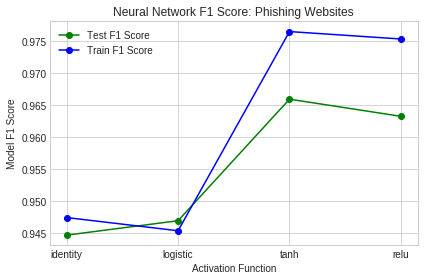

In [13]:
def tune_nn_activation(X_train, y_train, X_test, y_test, hyper_param):
    f1_test = []
    f1_train = []
    for i in hyper_param:
        clf = MLPClassifier(solver='adam', activation=i, random_state=0)
        clf.fit(X_train, y_train)
        y_pred_test = clf.predict(X_test)
        y_pred_train = clf.predict(X_train)
        f1_test.append(f1_score(y_test, y_pred_test))
        f1_train.append(f1_score(y_train, y_pred_train))
    return f1_train, f1_test
activations = ['identity', 'logistic', 'tanh', 'relu']
f1_train, f1_test = tune_nn_activation(X_train, y_train, X_test, y_test, activations)
plot_tune_curve(f1_train, f1_test, activations, xlabel='Activation Function',algor_name="Neural Network",
                    dataset_name="Phishing Websites")



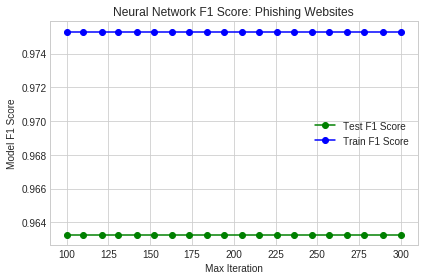

In [17]:
def tune_nn_max_iter(X_train, y_train, X_test, y_test, hyper_param):
    f1_test = []
    f1_train = []
    for i in hyper_param:
        clf = MLPClassifier(solver='adam', max_iter=i, random_state=0)
        clf.fit(X_train, y_train)
        y_pred_test = clf.predict(X_test)
        y_pred_train = clf.predict(X_train)
        f1_test.append(f1_score(y_test, y_pred_test))
        f1_train.append(f1_score(y_train, y_pred_train))
    return f1_train, f1_test 
max_iter = np.linspace(100, 300, 20).astype('int')
f1_train, f1_test = tune_nn_max_iter(X_train, y_train, X_test, y_test, max_iter)
plot_tune_curve(f1_train, f1_test, max_iter, xlabel='Max Iteration',algor_name="Neural Network",
                    dataset_name="Phishing Websites")

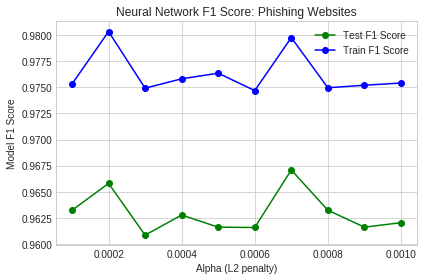

In [21]:
def tune_nn_alpha(X_train, y_train, X_test, y_test, hyper_param):
    f1_test = []
    f1_train = []
    for i in hyper_param:
        clf = MLPClassifier(solver='adam', alpha=i, random_state=0)
        clf.fit(X_train, y_train)
        y_pred_test = clf.predict(X_test)
        y_pred_train = clf.predict(X_train)
        f1_test.append(f1_score(y_test, y_pred_test))
        f1_train.append(f1_score(y_train, y_pred_train))
    return f1_train, f1_test 
alphas = np.linspace(0.0001, 0.001, 10)
f1_train, f1_test = tune_nn_alpha(X_train, y_train, X_test, y_test, alphas)
plot_tune_curve(f1_train, f1_test, alphas, xlabel='Alpha (L2 penalty)', algor_name="Neural Network",
                    dataset_name="Phishing Websites")


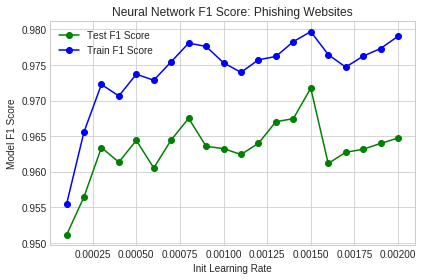

In [23]:
def tune_nn_learning_init(X_train, y_train, X_test, y_test, hyper_param):
    f1_test = []
    f1_train = []
    for i in hyper_param:
        clf = MLPClassifier(solver='adam', learning_rate_init=i, random_state=0)
        clf.fit(X_train, y_train)
        y_pred_test = clf.predict(X_test)
        y_pred_train = clf.predict(X_train)
        f1_test.append(f1_score(y_test, y_pred_test))
        f1_train.append(f1_score(y_train, y_pred_train))
    return f1_train, f1_test 
learning_rate_init = np.linspace(0.0001, 0.002, 20)
f1_train, f1_test = tune_nn_learning_init(X_train, y_train, X_test, y_test, learning_rate_init)
plot_tune_curve(f1_train, f1_test, learning_rate_init, xlabel='Init Learning Rate',algor_name="Neural Network",
                    dataset_name="Phishing Websites")